In [50]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

#from keras.models import Model, load_model
#from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
#from keras.layers.core import Lambda
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
#from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import concatenate
#from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img

### Reproducability setup:

In [51]:
import random as rn

kSeed = 241075

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(kSeed)
rn.seed(kSeed)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(kSeed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [52]:
# Set some parameters
img_size_ori = 101
img_size_target = 101
im_width = 101
im_height = 101
im_chan = 1
basicpath = '../../../../Kaggle_Data/Salt/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'



In [53]:
# Loading of training/testing ids and depths

train_df = pd.read_csv(basicpath+"/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(basicpath+"/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [54]:
train_df["images"] = [np.array(load_img(path_train_images+"{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))

In [55]:
train_df["masks"] = [np.array(load_img(path_train_masks+"{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))

# 1. Нулевые картинки и маски

In [ ]:
def c(mask):
    idx = (mask!=0) & (mask!=0) # change to test
    x = len((mask[idx]))
    return x
#c([0])
_ = train_df["masks"].map(c)
len(_[_ != 0])

In [58]:
train_df["mask_is_empty"] = (train_df.masks.map(np.max) == 0)
train_df["img_is_empty"] = (train_df.images.map(np.max) == 0)

In [59]:
len(train_df[train_df.img_is_empty]), \
  len(train_df[train_df.img_is_empty & ~train_df.mask_is_empty]), len(train_df[train_df.mask_is_empty])

(80, 0, 1562)

Выводы:   
    1. В масках нисего кроме 0,1 действительно нет
    2. Чисто 1 масок нет
    3. Непустых масок 2438 из 4000
    4. Чисто пустых картинок 80, на них везде маски пустые

In [60]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

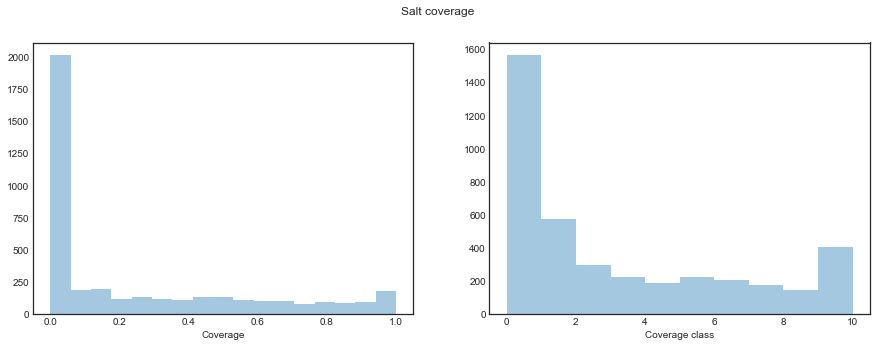

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


,z,mask_is_empty,img_is_empty,coverage
coverage_class,,,,
-1,520251,10201,0,0.0
1,601859,0,0,1.0
2,683467,0,0,1024.0
3,958894,0,0,2042.0
4,1397537,0,0,3064.0
5,907889,0,0,4084.0
6,1295527,0,0,5103.0
7,1162914,0,0,6121.0
8,1489346,0,0,7149.0


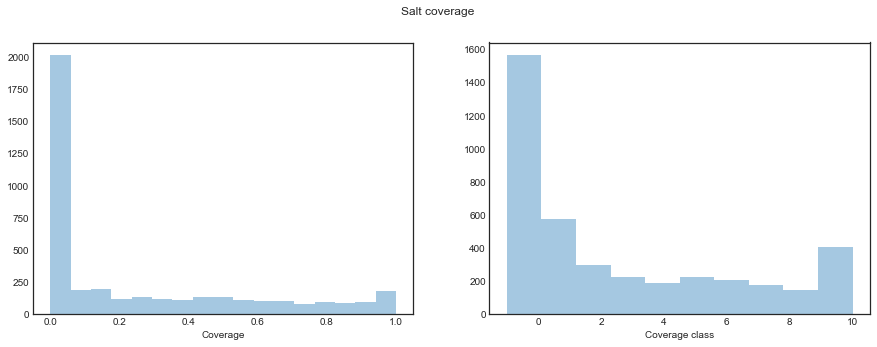

In [62]:
train_df.loc[train_df.mask_is_empty, 'coverage_class'] = -1
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
train_df.groupby(["coverage_class"]).min()*101*101

Выводы:  
    1. Предыдущее разбиение на классы и правда работает, 0 дает только пустым маскам

c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

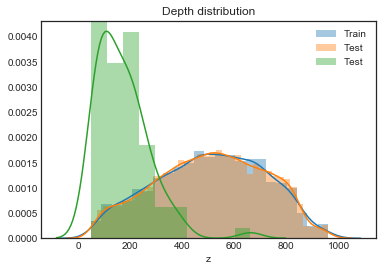

In [63]:
#Plotting the depth distributions¶
train_df
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
sns.distplot(train_df[train_df.img_is_empty].z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [64]:
sorted(depths_df[depths_df.index.isin(train_df.index)].z.unique())


[51,
 53,
 54,
 55,
 58,
 59,
 63,
 64,
 67,
 68,
 71,
 72,
 73,
 74,
 76,
 77,
 81,
 82,
 83,
 84,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 98,
 99,
 100,
 101,
 102,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 169,
 171,
 172,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,


# 2. Проверка наличия более 1 пятна маски

In [65]:
m1 = train_df.loc['2bc179b78c', 'masks']
cnn_output = cv2.connectedComponentsWithStats(m1.astype(np.uint8), 4)
len(cnn_output), cnn_output

(4, (2, array([[0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         ...,
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1]], dtype=int32), array([[   0,    0,   31,  101, 3131],
         [  31,    0,   70,  101, 7070]], dtype=int32), array([[15. , 50. ],
         [65.5, 50. ]])))

In [66]:
def mask_connected_components_info(m):
    return cv2.connectedComponentsWithStats(m.astype(np.uint8), 4)

train_df["mask_connected_components_info"] = train_df.masks.map(mask_connected_components_info)

# (count, masks, [(l,t,w,h,area)], [(x_centr, x_centr)])

In [67]:
train_df["mask_connected_components_info_count"] = train_df.mask_connected_components_info.apply(lambda x: x[0])


In [68]:
def center_val(x):
    r = []
    for i in range(x["mask_connected_components_info"][0]):
        center = x["mask_connected_components_info"][3][i]
        if i != x["mask_connected_components_info"][1][int(center[1]), int(center[0])]:
            print(i, x.name, center, x["mask_connected_components_info"][1][int(center[1]), int(center[0])])
        #assert x["mask_connected_components_info"][1][int(center[0]), int(center[1])]
        r.append(x['masks'][int(center[1]), int(center[0])])
    return r
train_df["mask_connected_components_info_bg_center_val"] = train_df.apply(center_val, axis = 1)


0 b45ad3932e [45.06705898 57.34446421] 1
0 9bf982cf65 [56.10268949 95.2200489 ] 1
0 36aa21019e [61.94142259 26.30357973] 1
0 1263576548 [29.86531175 33.73992422] 1
0 1d93614392 [40.45078405 33.67183072] 1
0 24a8ae9bb9 [98.8 99.8] 1
0 4b2af55ae6 [79.13141123 53.28437026] 1
1 6b996daecc [49.5262576  76.29988944] 0
1 b74ecdfe20 [74.30619469 89.04247788] 0
0 2717821409 [48.95043598 45.23129876] 1
1 4be85a3110 [99.66666667 99.66666667] 0
2 16589f0702 [99.7 97.6] 0
0 ecdd648857 [51.43368887 42.76132019] 1
0 05be526826 [48.09306931  9.43168317] 1
0 1804a4c064 [40.09711595 63.47969394] 1
0 16e308dbc3 [46.54730618 11.77989488] 1
1 e437c3912d [49.49390346 36.18606982] 0
0 9a672bfb51 [23.09090909  4.36363636] 1
0 e98557c9f3 [63.68658421 35.99714558] 1
0 f9a3d103d7 [57.96078431 45.46485671] 1
0 9898ce93d6 [54.18177656 46.67513736] 1
0 613fb95edf [42.66770307 45.47765255] 1
0 ca511bc319 [27.37600613 57.95400537] 1
0 d82b80a555 [92.7 40.1] 1
0 7ede03dede [41.77390773 49.69233119] 1
0 d0cba16846 [49.

2 0 1


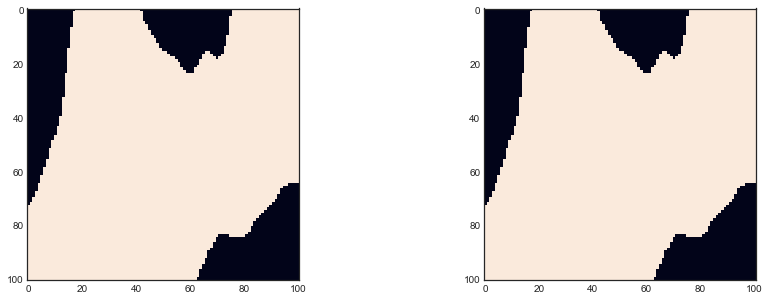

In [70]:
fix, axs = plt.subplots(1, 2, figsize=(15,5))
info = train_df.loc['2717821409', "mask_connected_components_info"]
pp = info[1]
axs[0].imshow(train_df.loc['2717821409', "masks"])
axs[1].imshow(pp)
print(info[0], pp[0,0], pp[75,50])

In [ ]:
train_df[(~train_df.mask_is_empty) & (train_df.mask_connected_components_info_count==4)][["mask_connected_components_info_bg_center_val", "mask_is_empty"]]

In [ ]:
def check_is_sq(x):
    r = x[2][0]
    m = r[4]/(r[2]*r[3])
    return m
    
train_df["mask_connected_components_info_rectness"] = train_df.mask_connected_components_info.apply(check_is_sq)    
    

In [ ]:
train_df[(~train_df.mask_is_empty) & (train_df.mask_connected_components_info_rectness==1) & (train_df.mask_connected_components_info_rectness>.99)].mask_connected_components_info_rectness

Выводы:
    1. 123 чисто прямоугольных картинки
    2. 173 не прямоугольных, но с rectness >0.99

In [1]:
bad_masks =('1eaf42beee','33887a0ae7','33dfce3a76','3975043a11','39cd06da7d','483b35d589','49336bb17b','4ef0559016','4fbda008c7','4fdc882e4b','50d3073821','53e17edd83','5b217529e7','5f98029612','608567ed23','62aad7556c','62d30854d7','6460ce2df7','6bc4c91c27','7845115d01','7deaf30c4a','80a458a2b6','81fa3d59b8','8367b54eac','849881c690','876e6423e6','90720e8172','916aff36ae','919bc0e2ba','a266a2a9df','a6625b8937','a9ee40cf0d','aeba5383e4','b63b23fdc9','baac3469ae','be7014887d','be90ab3e56','bfa7ee102e','bfbb9b9149','c387a012fc','c98dfd50ba','caccd6708f','cb4f7abe67','d0bbe4fd97','d4d2ed6bd2','de7202d286','f0c401b64b','f19b7d20bb','f641699848','f75842e215','00950d1627','0280deb8ae','06d21d76c4','09152018c4','09b9330300','0b45bde756','130229ec15','15d76f1672','182bfc6862','23afbccfb5','24522ec665','285f4b2e82','2bc179b78c','2f746f8726','3cb59a4fdc','403cb8f4b3','4f5df40ab2','50b3aef4c4','52667992f8','52ac7bb4c1','56f4bcc716','58de316918','640ceb328a','71f7425387','7c0b76979f','7f0825a2f0','834861f1b6','87afd4b1ca','88a5c49514','9067effd34','93a1541218','95f6e2b2d1','96216dae3b','96523f824a','99ee31b5bc','9a4b15919d','9b29ca561d','9eb4a10b98','ad2fa649f7','b1be1fa682','b24d3673e1','b35b1b412b','b525824dfc','b7b83447c4','b8a9602e21','ba1287cb48','be18a24c49','c27409a765','c2973c16f1','c83d9529bd','cef03959d8','d4d34af4f7','d9a52dc263','dd6a04d456','ddcb457a07','e12cd094a6','e6e3e58c43','e73ed6e7f2','f6e87c1458','f7380099f6','fb3392fee0','fb47e8e74e','febd1d2a67')
len(bad_masks)

113

# 3. Поиск похожих картинок

In [ ]:
train_w_mask = train_df[(train_df.coverage_class >=3) & (train_df.coverage_class <=8)]
len(train_w_mask)

In [ ]:
def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

pair_dist = [(1-iou(x.masks,y.masks), i1,i2) for i1, x in  tqdm_notebook(train_w_mask.iterrows()) for i2,y in  train_w_mask.iterrows() if i2!=i1]

In [ ]:
pair_dist.sort()

In [ ]:
_ = [(x, depths_df.loc[x[1], 'z'], depths_df.loc[x[2], 'z']) for x in pair_dist[:1000] if x[1]== '93a1541218']
_.sort(key = lambda x: x[2])
for xx in _:
    print(xx)

In [ ]:

for x in pair_dist[:10000]:
 if x[1]== '7f0825a2f0':
  if x[1]<x[2] :
    print(x, depths_df.loc[x[1], 'z'], depths_df.loc[x[2], 'z'])

In [ ]:

m1 = train_df.loc['0061281eea', 'masks']
m2 = train_df.loc['196cffdb4b', 'masks']
print(np.sum((m1*m2) >0))
print(np.sum((m1 + m2) >0))
print( iou(m1,m2 ))

# N. Остаток исходного кернела

In [ ]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [ ]:
ACTIVATION = "relu"

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation(ACTIVATION)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation(ACTIVATION)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x


In [ ]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation(ACTIVATION)(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [ ]:
thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

In [ ]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

In [ ]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [ ]:
early_stopping = EarlyStopping(monitor='val_acc', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./unet_best1.model",monitor='val_acc', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode = 'max',factor=0.2, patience=5, min_lr=0.00001, verbose=1)
#reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 25

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

In [ ]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['acc'][1:])
plt.plot(history.history['val_acc'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()


In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")

In [ ]:
model = load_model("./unet_best1.model")

In [ ]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test/2.0

In [ ]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [ ]:
def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric(y_valid.reshape((-1, img_size_target, img_size_target)), [filter_image(img) for img in preds_valid > threshold]) for threshold in tqdm_notebook(thresholds)])


In [ ]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [ ]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
import gc

del x_train, x_valid, y_train, y_valid, preds_valid
gc.collect()

In [ ]:
x_test = np.array([(np.array(load_img(path_test_images+"{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = predict_result(model,x_test,img_size_target)

In [ ]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(filter_image(preds_test[i] > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv.gz', compression = 'gzip')

In [ ]:
sub.head(10)